# FDW Crop production data profiling - ET admin level 2

In [1]:
import os, sys, glob, json
from itertools import product, compress, chain
from functools import reduce
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
from tools import save_hdf, save_npz, load_npz, PrintAdminUnits, PlotAdminShapes
from tools import FDW_PD_Sweeper, FDW_PD_AvalTable, FDW_PD_Compiling, FDW_PD_GrainTypeAgg, FDW_PD_ValidateFnidName
from tools import FDW_PD_CreateAdminLink, FDW_PD_RatioAdminLink, FDW_PD_ConnectAdminLink
from tools import FDW_PD_CaliSeasonYear
from tools_graphic import PlotBarProduction, PlotLinePAY, PlotHeatCropSystem, PlotHeatSeasonData
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
pd.options.mode.chained_assignment = None
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)


In [2]:
# CPCV2 grain code ------------------------------ #
grain_code = pd.read_hdf('./data/crop/grain_cpcv2_code.hdf')
product_category = grain_code[['product', 'product_category']].set_index('product').to_dict()['product_category']
# ----------------------------------------------- #

# Load FEWS NET administrative boundaries ------- #
epsg = 'EPSG:32638'
fn_shapes = sorted(glob.glob('./data/shapefile/fewsnet/ET_Admin?_????.shp'))
shape_all = []
for fn in fn_shapes:
    name = fn[-18:-4]
    exec('%s = gpd.read_file("%s").to_crs("%s")' % (name, fn, epsg))
    exec('%s["area"] = %s["geometry"].area/10**6' % (name, name))
    exec('shape_all.append(%s)' % (name))
shape_all = pd.concat(shape_all, axis=0).reset_index(drop=True)
PrintAdminUnits(shape_all)
# ----------------------------------------------- #

# FDW API host address -------------------------- #
host = 'https://fdw.fews.net'
#read in username and password
exec(open('/Users/wanders7/Documents/Code/Logins/FDW.py').read())
auth = (username, password)
parameters = {
    'format': 'json',
    'country': 'Ethiopia',
    'product': 'R011',
    'survey_type': 'crop:best'
}
endpoint = '/api/cropproductionindicatorvalue/'
response = requests.get(host + endpoint, auth=auth, params=parameters, proxies={},verify=False)
response.raise_for_status()
df = pd.DataFrame.from_records(response.json())
df_origin = df.copy()
# ----------------------------------------------- #

- FEWS NET admin shapefiles ------------------- #
| year	 | Admin1   | # units   | Admin2   | # units   |
| 1994	 | ET1994A1 | 11	| ET1994A2	| 66	|
| 2001	 | ET2001A1 | 11	| ET2001A2	| 68	|
| 2003	 | ET2003A1 | 11	| ET2003A2	| 73	|
| 2007	 | ET2007A1 | 11	| ET2007A2	| 75	|
| 2008	 | ET2008A1 | 11	| ET2008A2	| 80	|
| 2014	 | ET2014A1 | 11	| ET2014A2	| 77	|
| 2019	 | ET2019A1 | 11	| ET2019A2	| 84	|
| 2020	 | ET2020A1 | 11	| ET2020A2	| 91	|
----------------------------------------------- #


/Users/wanders7/opt/anaconda3/lib/python3.8/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'fdw.fews.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


In [3]:

# Manual Pre-processing before Sweeping --------- #
# 1. Default setting
# a.1) None-type crop production system
df.loc[df['crop_production_system'].isna(), 'crop_production_system'] = 'none'
df.loc[df['crop_production_system'] == '', 'crop_production_system'] = 'none'
# a.2) Early in the record the catch-all crop production system is 'all' rather than none. Make these to none-type
df.loc[df['crop_production_system'] == 'all', 'crop_production_system'] = 'none'
# b) None-type population group
df.loc[df['population_group'].isna(), 'population_group'] = 'none'
df.loc[df['population_group'] == '', 'population_group'] = 'none'
# ----------------------------------------------- #
#Drop the blank (nan) rows that are duplicates of rows that do have data
df=df[np.isfinite(df.value)]
#limit the data to admin 2 resolution
df=df.dropna(subset=['admin_2'])
rows = ['fnid','season_year', 'product','indicator','crop_production_system']

#The Maize Grain (Fresh) crop code only exists in 2020, when the yield issue was fixed, but there are now duplicates of the data
# drop the Maize (Corn) data in 2020, then rename the crop data for Maize Grain (Fresh) to Maize (corn)
df = df[~((df['product'] == 'Maize (Corn)')&(pd.to_datetime(df.period_date).dt.year==2020))]
df.loc[(df['product'] == 'Maize Grain (Fresh)'),'product'] = 'Maize (Corn)'

#Barley (White) only exists in years/areas where Barley (Unspecified) does not exist. Rename to a single Barley (Unspecified) class
df.loc[(df['product'] == 'Barley (White)'),'product'] = 'Barley (Unspecified)'

# FDW Production Data Inspection ---------------- #
df, df_raw = FDW_PD_Sweeper(df)
table_dict = FDW_PD_AvalTable(df, shape_all)
# ----------------------------------------------- #

# # FEWS NET Shapefile comparison ----------------- #
shape_used = pd.concat([ET_Admin2_1994,ET_Admin2_2001,ET_Admin2_2003,ET_Admin2_2007,ET_Admin2_2008,ET_Admin2_2014,ET_Admin2_2019,ET_Admin2_2020], axis=0)
PlotAdminShapes(shape_used, label=True)
# # ----------------------------------------------- #


- Remove missing records ---------------------- #
Orignial data points: 15,388
Removed 40 "Missing Value" points
5,292/5,292 "Area Planted" points are retained.
5,046/5,055 "Quantity Produced" points are retained.
5,010/5,041 "Yield" points are retained.
Current data points: 15,348

- Minor changes are applied ------------------- #

- Basic information --------------------------- #
Data period: 1998 - 2019
8 grain types are found: Barley (Unspecified), Maize (Corn), Millet (Finger), Mixed Teff, Oats (Unspecified), Rice (Paddy), Sorghum, Wheat Grain
1 seasons are found: Meher (10-01)
1 crop production system are found: none
Data sources include:
[1] Central Statistical Agency, Ethiopia:  --- Agricultural Sample Survey, Ethiopia
[2] Central Statistics Office (CSO), Ethiopia --- Central Statistical Agency, Ethiopia
Administrative-1 fnids: 0
Administrative-2 fnids: 446
0 reporting units are found: 

- Total production over time ------------------ #
season_name           Meher
             

In [4]:
sorted(list(df_origin['season_year'].unique()))

# Define the latest shapefile ------------------- #
latest_level = 2
shape_latest = ET_Admin2_2014.copy().to_crs('epsg:4326')
# ----------------------------------------------- #

# Validation of FNIDs and Names ----------------- #
df = FDW_PD_ValidateFnidName(df, shape_used, shape_latest)
# ----------------------------------------------- #

# FDW Production Data Compiling ----------------- #
area, prod = FDW_PD_Compiling(df, shape_used)
area_all, prod_all = area.copy(), prod.copy()
mdx_pss = area.columns.droplevel([0,1]).unique()
# ----------------------------------------------- #

ET2019A21202:	"Agniwak" (FDW) is changed to "Nuer" (shapefile).
ET2019A20717:	"Dawuro" (FDW) is changed to "Dawro" (shapefile).
ET2019A21204:	"Etang Special" (FDW) is changed to "Itang" (shapefile).
ET2019A20420:	"Finfine Special" (FDW) is changed to "Finfinne Special" (shapefile).
ET2019A20414:	"Guji" (FDW) is changed to "Gujii" (shapefile).
ET2019A20701:	"Guraghe" (FDW) is changed to "Gurage" (shapefile).
ET2019A20721:	"Halaba Special" (FDW) is changed to "Alaba" (shapefile).
ET2019A20419:	"Horo Gudru Wellega" (FDW) is changed to "Horo Guduru" (shapefile).
ET2019A20403:	"Ilu Aba Bora" (FDW) is changed to "Ilubabor" (shapefile).
ET2019A20709:	"Kefa" (FDW) is changed to "Keffa" (shapefile).
ET2019A20418:	"Kelem Wellega" (FDW) is changed to "Kelem" (shapefile).
ET2019A20703:	"Kembata Tibaro" (FDW) is changed to "Kembata Tembaro" (shapefile).
ET2019A20719:	"Konta Special" (FDW) is changed to "Konta" (shapefile).
ET2019A20605:	"Mao Komo Special" (FDW) is changed to "Mao-Komo" (shapefile).

In [5]:
# Link admin boundaries ------------------------- #
link_1994, over_1994 = FDW_PD_CreateAdminLink(ET_Admin2_1994, ET_Admin2_2014, 'ADMIN2', 'ADMIN2', prod, epsg)
link_2001, over_2001 = FDW_PD_CreateAdminLink(ET_Admin2_2001, ET_Admin2_2014, 'ADMIN2', 'ADMIN2', prod, epsg)
link_2003, over_2003 = FDW_PD_CreateAdminLink(ET_Admin2_2003, ET_Admin2_2014, 'ADMIN2', 'ADMIN2', prod, epsg)
link_2007, over_2007 = FDW_PD_CreateAdminLink(ET_Admin2_2007, ET_Admin2_2014, 'ADMIN2', 'ADMIN2', prod, epsg)
link_2008, over_2008 = FDW_PD_CreateAdminLink(ET_Admin2_2008, ET_Admin2_2014, 'ADMIN2', 'ADMIN2', prod, epsg)

# Crop specific ratios
link_ratio_1994 = FDW_PD_RatioAdminLink(link_1994, prod, over_1994, mdx_pss)
link_ratio_2001 = FDW_PD_RatioAdminLink(link_2001, prod, over_2001, mdx_pss)
link_ratio_2003 = FDW_PD_RatioAdminLink(link_2003, prod, over_2003, mdx_pss)
link_ratio_2007 = FDW_PD_RatioAdminLink(link_2007, prod, over_2007, mdx_pss)
link_ratio_2008 = FDW_PD_RatioAdminLink(link_2008, prod, over_2008, mdx_pss)

# Merge link_ratio
assert link_ratio_1994.keys() == link_ratio_2008.keys()
assert link_ratio_2001.keys() == link_ratio_2008.keys()
assert link_ratio_2003.keys() == link_ratio_2008.keys()
assert link_ratio_2007.keys() == link_ratio_2008.keys()
link_merged = [link_ratio_1994, link_ratio_2001,link_ratio_2003,link_ratio_2007]
fnids_new = list(link_merged[0].keys())
link_ratio = dict()
for fnid in fnids_new:
    container = []
    for link in link_merged:
        container.append(link[fnid])
    link_ratio[fnid] = pd.concat(container, axis=1)
# Add current unit to link_ratio
for fnid_new in link_ratio.keys():
    link_ratio[fnid_new][fnid_new] = 1.0
    link_ratio[fnid_new] = link_ratio[fnid_new].sort_index(axis=1, ascending=False)
# Connect data with AdminLink
area_new, prod_new = FDW_PD_ConnectAdminLink(link_ratio, area, prod, validation=False)
# ----------------------------------------------- #


CBR is considered for 'ET1994A21603' as no record found in: ['ET2014A20503']
CBR is considered for 'ET1994A21604' as no record found in: ['ET2014A20504']
CBR is considered for 'ET1994A21614' as no record found in: ['ET2014A20507']
CBR is considered for 'ET1994A20202' as no record found in: ['ET2014A20202']
CBR is considered for 'ET1994A20204' as no record found in: ['ET2014A20204']
CBR is considered for 'ET1994A20205' as no record found in: ['ET2014A20205']
CBR is considered for 'ET1994A21410' as no record found in: ['ET2014A21410']
CBR is considered for 'ET2001A20508' as no record found in: ['ET2014A20508']
CBR is considered for 'ET2001A20503' as no record found in: ['ET2014A20503']
CBR is considered for 'ET2001A20504' as no record found in: ['ET2014A20504']
CBR is considered for 'ET2001A20506' as no record found in: ['ET2014A20506']
CBR is considered for 'ET2001A20505' as no record found in: ['ET2014A20505']
CBR is considered for 'ET2001A20507' as no record found in: ['ET2014A20507']

In [6]:
# Manual correction ----------------------------- #
crop_new = prod_new/area_new

# Complete long format DataFrame ---------------- #
df_area = area_new.T.stack().rename('value').reset_index()
df_area['indicator'] = 'area'
df_prod = prod_new.T.stack().rename('value').reset_index()
df_prod['indicator'] = 'production'
df_yield = (prod_new/area_new).T.stack().rename('value').reset_index()
df_yield['indicator'] = 'yield'
stack = pd.concat([df_area, df_prod, df_yield], axis=0)
# Add "growing year"
cols = ['season_name','product','crop_production_system','growing_month','harvest_year','harvest_month','growing_year']
season_table = df[cols].drop_duplicates()
stack = stack.merge(season_table, on=cols[:-1])
# Add country and admin names
stack = stack.merge(df[['fnid','country','country_code','admin_1','admin_2']].drop_duplicates(), on='fnid', how='inner')
names = [
    'fnid','country','country_code','admin_1','admin_2','name',
    'product','season_name','growing_year','growing_month','harvest_year','harvest_month',
    'crop_production_system','indicator','value'
]
stack_gscd = stack[names]
stack_gscd['gscd_code'] = 'calibrated'
# ----------------------------------------------- #
# Reported FDW data ----------------------------- #
stack_fdw = df[names]
stack_fdw['indicator'] = stack_fdw['indicator'].replace({'Area Harvested':'area','Quantity Produced':'production','Yield':'yield'})
stack_fdw['gscd_code'] = 'reported'
# ----------------------------------------------- #
# Final Processing ------------------------------ #
stack = pd.concat([stack_fdw,stack_gscd], axis=0).reset_index(drop=True)
# No concerns found for grain types
stack['product'] = stack['product'].replace(product_category)
# Calibration of Growing and Harvest year and season
cs = {
    'Meher': {'growing_month':{'10-01':'10-01'},'harvest_month':{'01-01':'01-01'}},
}
cy = {}
stack, df, link_ratio = FDW_PD_CaliSeasonYear(stack, df, link_ratio, cs, cy)
stack.loc[stack['admin_1'].isna(), 'admin_1'] = 'none'
stack.loc[stack['admin_2'].isna(), 'admin_2'] = 'none'
# # ----------------------------------------------- #

# Save data
save_hdf('./data/crop/adm_crop_production_ET.hdf', stack)
save_hdf('./data/crop/adm_crop_production_ET_raw.hdf', df)
save_npz('./data/crop/adm_crop_production_ET_ratio.npz', link_ratio)


./data/crop/adm_crop_production_ET.hdf is saved.
./data/crop/adm_crop_production_ET_raw.hdf is saved.
./data/crop/adm_crop_production_ET_ratio.npz is saved.


In [7]:
stack_gscd

fnid   country country_code admin_1           admin_2  \
0      ET2014A20101  Ethiopia           ET  Tigray  Northwest Tigray   
1      ET2014A20101  Ethiopia           ET  Tigray  Northwest Tigray   
2      ET2014A20101  Ethiopia           ET  Tigray  Northwest Tigray   
3      ET2014A20101  Ethiopia           ET  Tigray  Northwest Tigray   
4      ET2014A20101  Ethiopia           ET  Tigray  Northwest Tigray   
...             ...       ...          ...     ...               ...   
10778  ET2014A20705  Ethiopia           ET   SNNPR             Gedeo   
10779  ET2014A20705  Ethiopia           ET   SNNPR             Gedeo   
10780  ET2014A20705  Ethiopia           ET   SNNPR             Gedeo   
10781  ET2014A20705  Ethiopia           ET   SNNPR             Gedeo   
10782  ET2014A20705  Ethiopia           ET   SNNPR             Gedeo   

                   name          product season_name  growing_year  \
0      Northwest Tigray  Millet (Finger)       Meher          1998   
1      Northwest Tigray  Millet (Finger)       Meher          1998   
2      Northwest Tigray  Millet (Finger)       Meher          1998   
3      Northwest Tigray  Millet (Finger)       Meher          1999   
4      Northwest Tigray  Millet (Finger)       Meher          1999   
...                 ...              ...         ...           ...   
10778             Gedeo      Wheat Grain       Meher          2005   
10779             Gedeo      Wheat Grain       Meher          2006   
10780             Gedeo      Wheat Grain       Meher          2006   
10781             Gedeo      Wheat Grain       Meher          2006   
10782             Gedeo      Wheat Grain       Meher          2017   

      growing_month  harvest_year harvest_month crop_production_system  \
0             10-01          1999         01-01                   none   
1             10-01          1999         01-01                   none   
2             10-01          1999         01-01                   none   
3             10-01          2000         01-01                   none   
4             10-01          2000         01-01                   none   
...             ...           ...           ...                    ...   
10778         10-01          2006         01-01                   none   
10779         10-01          2007         01-01                   none   
10780         10-01          2007         01-01                   none   
10781         10-01          2007         01-01                   none   
10782         10-01          2018         01-01                   none   

        indicator         value   gscd_code  
0            area  37316.973552  calibrated  
1      production  34352.232780  calibrated  
2           yield      0.920552  calibrated  
3            area  33902.779728  calibrated  
4      production  36190.454527  calibrated  
...           ...           ...         ...  
10778       yield      1.601735  calibrated  
10779        area    282.790000  calibrated  
10780  production    259.080000  calibrated  
10781       yield      0.916157  calibrated  
10782        area    440.870000  calibrated  

[10783 rows x 16 columns]

./figures/ET_bar_natgrainprod_Meher.png is saved.


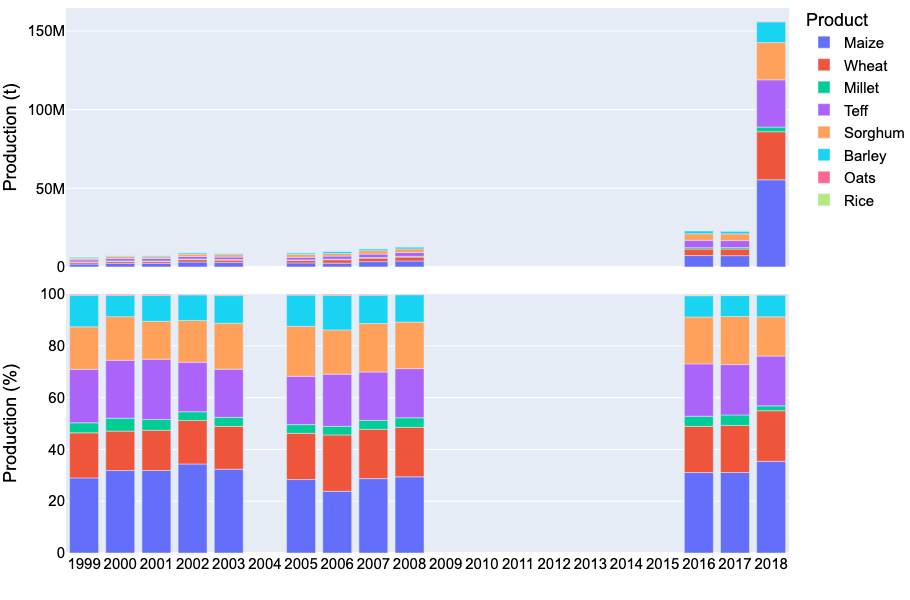

In [8]:
# Bar chart of national grain production
country_iso, country_name = 'ET', 'Ethiopia'
df = pd.read_hdf('./data/crop/adm_crop_production_%s.hdf' % country_iso)
df = df[df['gscd_code']=='calibrated']; df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
product_order = ['Maize', 'Wheat','Millet', 'Teff','Sorghum','Barley','Oats','Rice']
for season_name in ['Meher']:
    footnote = 'National grain production in %s - %s' % (country_name, season_name)
    fn_save = './figures/%s_bar_natgrainprod_%s.png' % (country_iso, season_name)
    sub = df[df['season_name'] == season_name]
    fig = PlotBarProduction(sub, year, product_order, footnote, fn_save)
    fig.show()


./figures/ET_line_pay_Barley_Meher.png is saved.


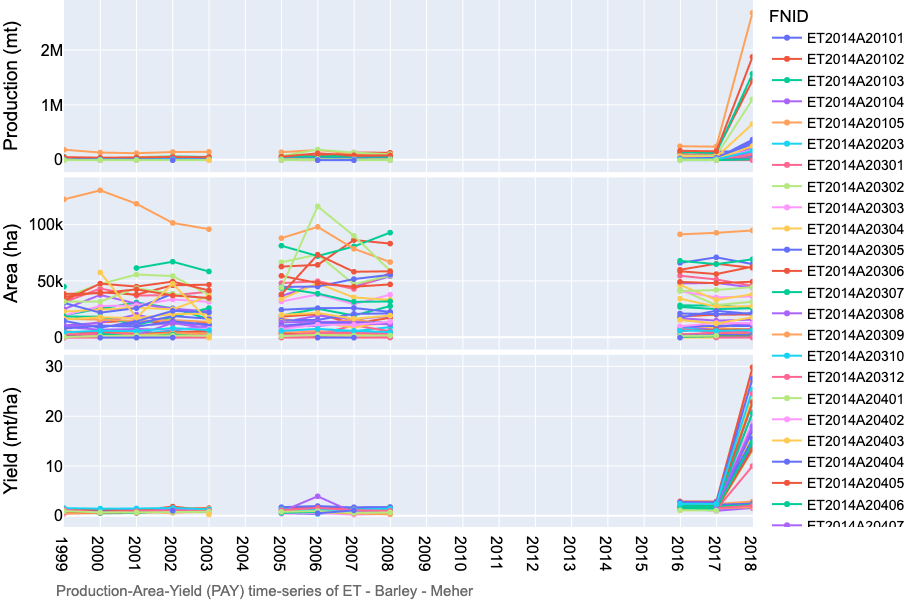

./figures/ET_line_pay_Maize_Meher.png is saved.


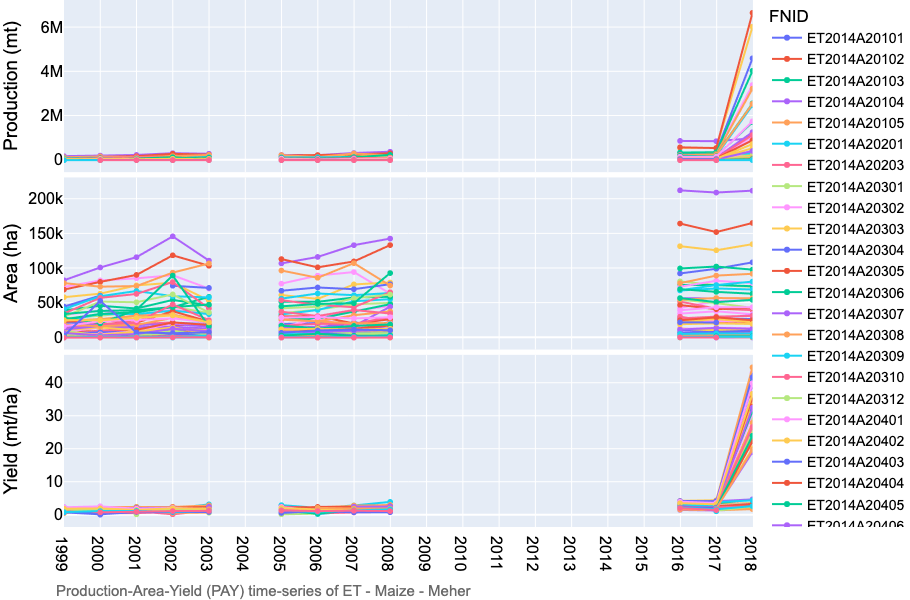

./figures/ET_line_pay_Millet_Meher.png is saved.


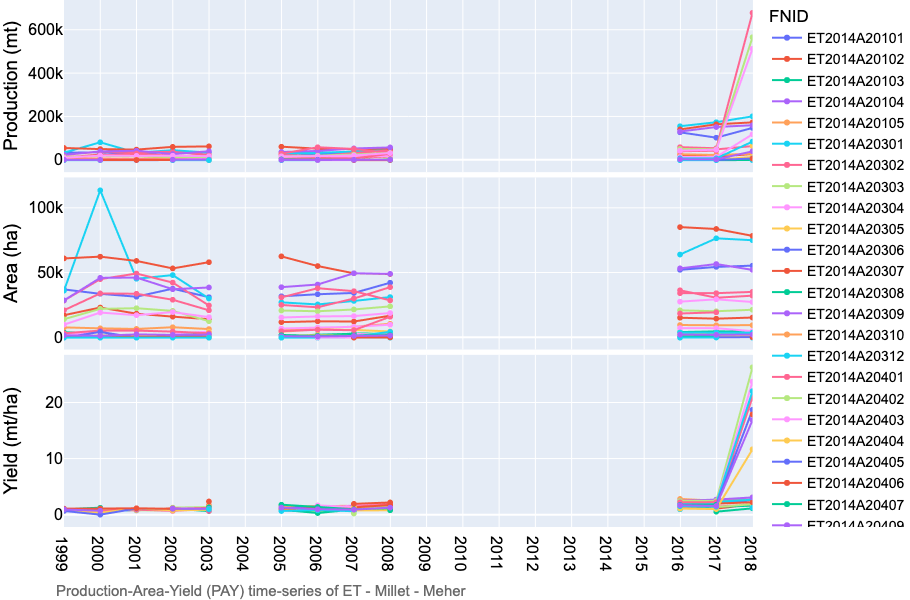

./figures/ET_line_pay_Teff_Meher.png is saved.


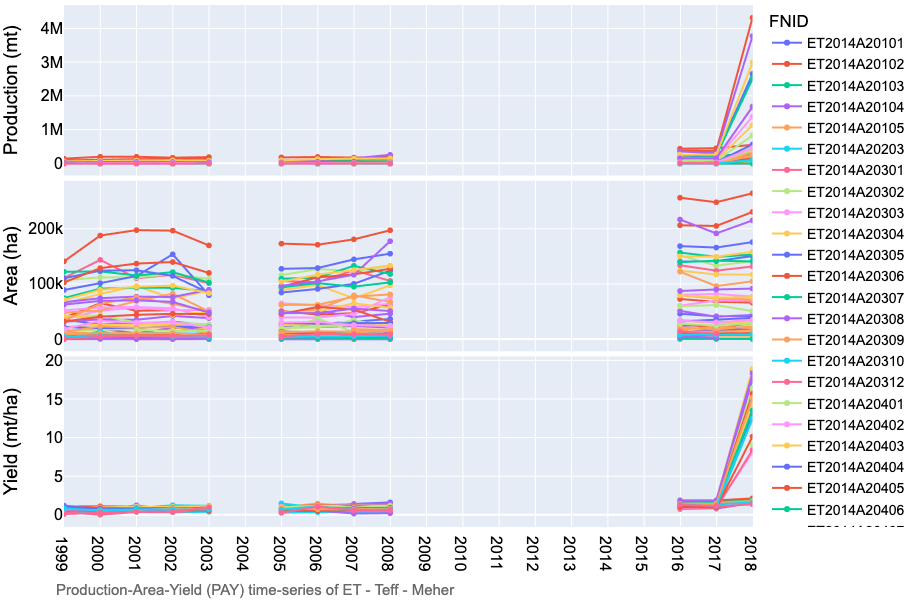

./figures/ET_line_pay_Sorghum_Meher.png is saved.


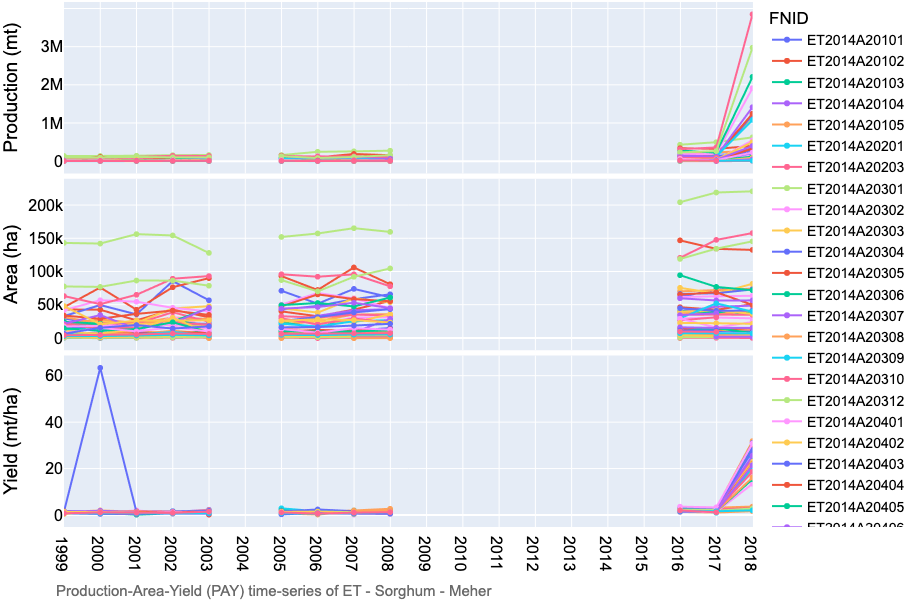

./figures/ET_line_pay_Wheat_Meher.png is saved.


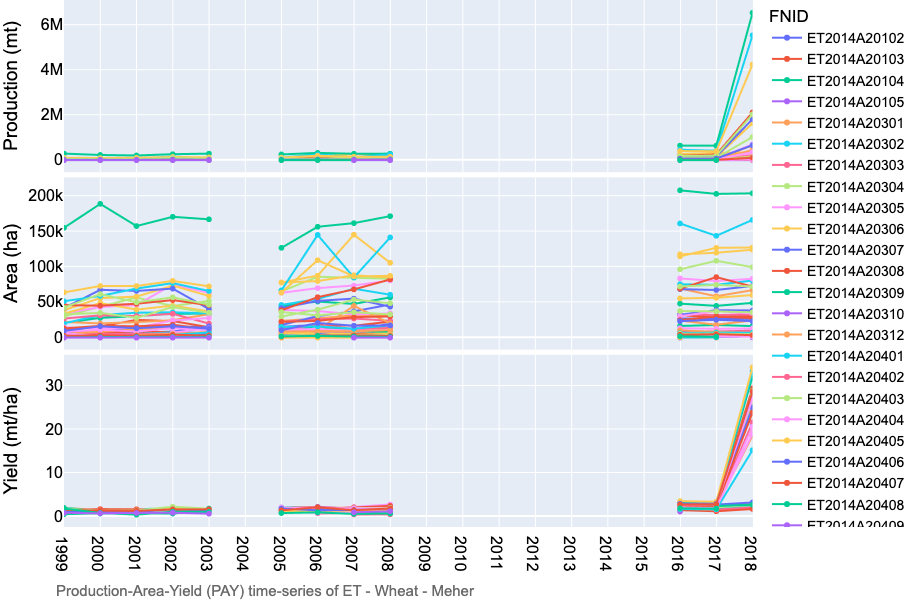

./figures/ET_line_pay_Rice_Meher.png is saved.


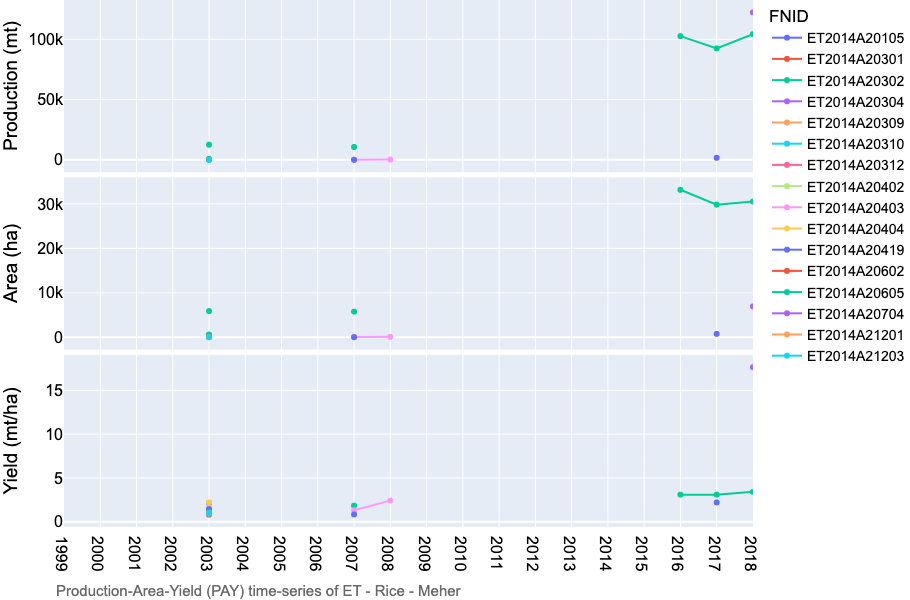

./figures/ET_line_pay_Oats_Meher.png is saved.


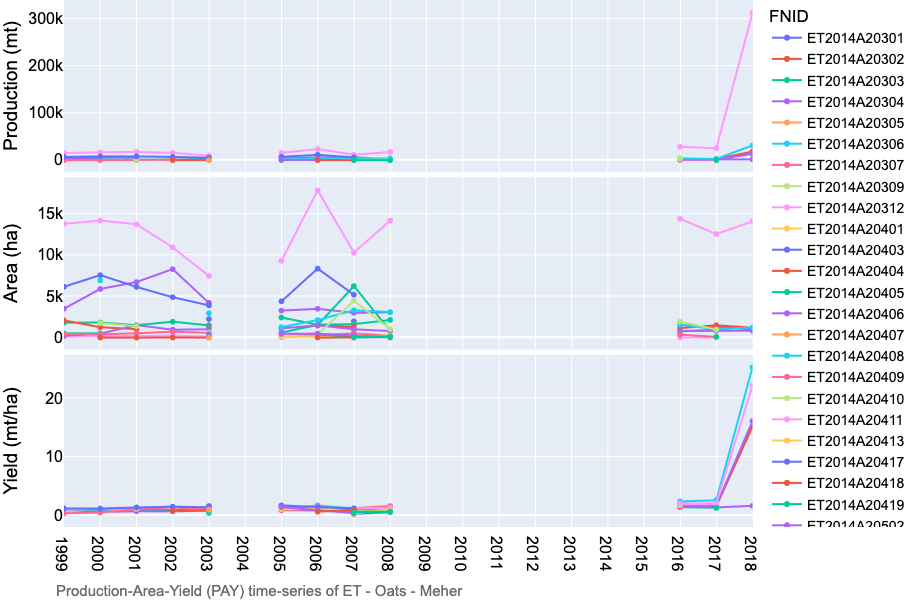

In [9]:
# Lineplot of Production-Area-Yield (PAY) time-series
country_iso, country_name = 'ET', 'Ethiopia'
df = pd.read_hdf('./data/crop/adm_crop_production_%s.hdf' % country_iso)
df = df[df['gscd_code']=='calibrated']; df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
product_season = [
    ['Barley', 'Meher'],
    ['Maize', 'Meher'],
    ['Millet', 'Meher'],
    ['Teff', 'Meher'],
    ['Sorghum', 'Meher'],
    ['Wheat', 'Meher'],
    ['Rice', 'Meher'],
    ['Oats', 'Meher'],
]
for product_name, season_name in product_season:
    footnote = 'Production-Area-Yield (PAY) time-series of %s - %s - %s' % (country_iso, product_name, season_name)
    fn_save = './figures/%s_line_pay_%s_%s.png' % (country_iso, product_name, season_name)
    sub = df[(df['product'] == product_name) & (df['season_name'] == season_name)]
    fig = PlotLinePAY(sub, year, footnote, fn_save)
    fig.show()

In [10]:
# Calibrated PAY time-series per FNID
from tools_graphic import PlotLineCropTS
country_iso, country_name = 'ET', 'Ethiopia'
df = pd.read_hdf('./data/crop/adm_crop_production_%s.hdf' % country_iso)
df = df[df['gscd_code']=='calibrated']; df['year'] = df['harvest_year']
link_ratio = load_npz('./data/crop/adm_crop_production_%s_ratio.npz' % country_iso)
year_all = np.arange(df['year'].min(), df['year'].max()+1)
product_season = [
    ['Barley', 'Meher'],
    ['Maize', 'Meher'],
    ['Millet', 'Meher'],
    ['Teff', 'Meher'],
    ['Sorghum', 'Meher'],
    ['Wheat', 'Meher'],
    ['Rice', 'Meher'],
    ['Oats', 'Meher'],
]
for product_name, season_name in product_season:
    sub = df[
        (df['product'] == product_name) &
        (df['season_name'] == season_name)
    ]
    for fnid in sub['fnid'].unique():
        sub_fps = sub[sub['fnid'] == fnid]
        fn_save = './figures/crop_calibrated/%s_%s_%s_%s.png' % (country_iso, product_name, season_name, fnid)
        fig = PlotLineCropTS(sub_fps, fnid, product_name, season_name, link_ratio, year_all, fn_save)


./figures/crop_calibrated/ET_Barley_Meher_ET2014A20101.png is saved.
./figures/crop_calibrated/ET_Barley_Meher_ET2014A20102.png is saved.
./figures/crop_calibrated/ET_Barley_Meher_ET2014A20103.png is saved.
./figures/crop_calibrated/ET_Barley_Meher_ET2014A20104.png is saved.
./figures/crop_calibrated/ET_Barley_Meher_ET2014A20105.png is saved.
./figures/crop_calibrated/ET_Barley_Meher_ET2014A20301.png is saved.
./figures/crop_calibrated/ET_Barley_Meher_ET2014A20302.png is saved.
./figures/crop_calibrated/ET_Barley_Meher_ET2014A20307.png is saved.
./figures/crop_calibrated/ET_Barley_Meher_ET2014A20309.png is saved.
./figures/crop_calibrated/ET_Barley_Meher_ET2014A20401.png is saved.
./figures/crop_calibrated/ET_Barley_Meher_ET2014A20402.png is saved.
./figures/crop_calibrated/ET_Barley_Meher_ET2014A20403.png is saved.
./figures/crop_calibrated/ET_Barley_Meher_ET2014A20407.png is saved.
./figures/crop_calibrated/ET_Barley_Meher_ET2014A20417.png is saved.
./figures/crop_calibrated/ET_Barle